In [119]:
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_log_error, mean_squared_error,  r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pandas as pd
import os
import warnings

warnings.filterwarnings("ignore")

pd.options.display.float_format = "{:,.2f}".format
pd.options.display.max_rows = 50
pd.options.display.max_columns = 40

In [180]:
raw_data = pd.read_csv("./Data/BikeSharingDemand/Bike_Sharing_Demand_Full.csv")

In [228]:
def non_feature_engineering(data):
    data = raw_data
    data["datetime"] = pd.to_datetime(data["datetime"])
    data = data.set_index("datetime", drop=False)
    # Set frequency
    data = data.asfreq("H", method="ffill")
    return data

def feature_engineering(data):
    data = non_feature_engineering(raw_data)
    
    # Split dataset as Trend + Seasonal + Residual
    decomp = sm.tsa.seasonal_decompose(data["count"], model="additive")

    y_trend = pd.DataFrame(decomp.trend)
    y_trend.columns = ["count_trend"]
    y_trend.fillna(method="ffill", inplace=True)
    y_trend.fillna(method="bfill", inplace=True)

    y_seasonal = pd.DataFrame(decomp.seasonal)
    y_seasonal.columns = ["count_seasonal"]
    y_seasonal.fillna(method="ffill", inplace=True)
    y_seasonal.fillna(method="bfill", inplace=True)

    data = pd.concat([data, y_trend, y_seasonal], axis=1)
    
    # Add moving average
    y_roll_day = data[["count"]].rolling(24).mean()
    y_roll_day.columns = ["count_day"]
    y_roll_day.fillna(method="ffill", inplace=True)
    y_roll_day.fillna(method="bfill", inplace=True)

    y_roll_week = data[["count"]].rolling(24*7).mean()
    y_roll_week.columns = ["count_week"]
    y_roll_week.fillna(method="ffill", inplace=True)
    y_roll_week.fillna(method="bfill", inplace=True)

    data = pd.concat([data, y_roll_day, y_roll_week], axis=1)
    
    # Add difference
    y_diff = data[["count"]].diff()
    y_diff.columns = ["count_diff"]
    y_diff = y_diff.fillna(method="ffill")
    y_diff = y_diff.fillna(method="bfill")
    data = pd.concat([data, y_diff], axis=1)
    
    # Add categorical variables
    data["year"] = data["datetime"].dt.year
    data["Q"] = data["datetime"].dt.quarter
    data["Q2"] = data["Q"]*(data["year"] - data["year"].min() + 1)
    data["month"] = data["datetime"].dt.month
    data["day"] = data["datetime"].dt.day
    data["hour"] = data["datetime"].dt.hour
    data["dayofweek"] = data["datetime"].dt.dayofweek
    
    # Add lagged variables
    data["count_lag1"] = data["count"].shift(1)
    data["count_lag2"] = data["count"].shift(2)

    data["count_lag1"] = data["count_lag1"].fillna(method="bfill")
    data["count_lag2"] = data["count_lag2"].fillna(method="bfill")
    
    # Add dum variables
    data = pd.concat([data, pd.get_dummies(data["Q"], prefix="Q_dum", drop_first=True)], axis=1)
    data = data.drop(["Q"], axis=1)
    return data

def data_split(data, x_cols, y_cols, crit):
    tr = data[data.index < crit]
    test = data[data.index >= crit]
    
    x_tr = tr[x_cols]
    y_tr = tr[y_cols]
    x_te = test[x_cols]
    y_te = test[y_cols]
    return x_tr, y_tr, x_te, y_te

In [230]:
data_fe = feature_engineering(raw_data)

y_cols = ["count"]
x_cols = [x for x in data_fe.columns if x not in ["datetime", "casual", "registered"] + y_cols]
x_tr, y_tr, x_te, y_te = data_split(data_fe, x_cols=x_cols, y_cols=y_cols, crit="2012-07-01")

In [123]:
# # plt.style.use("default")
# fig, axes = plt.subplots(1, 1, figsize=(len(x_tr)/1600, 4))
# fig = x_tr["count_trend"].plot.line(ax=axes, fontsize=7)

# fig, axes = plt.subplots(1, 1, figsize=(len(x_te)/1600, 4))
# fig = x_te["count_trend"].plot.line(ax=axes, fontsize=7)

# Additional Feature Engineering

## 시간현실반영

In [186]:
def duplicate_values(data, target):
    for col in target:
        data.loc["2012-01-01":"2012-02-28", col] = data.loc["2011-01-01":"2011-02-28", col].values
        data.loc["2012-03-01":"2012-12-31", col] = data.loc["2011-03-01":"2011-12-31", col].values
        
        # Perform linear interpolation
        step = (data.loc["2011-03-01 00:00:00", col] - data.loc["2011-02-28 23:00:00", col])/25
        values = np.arange(data.loc["2011-02-28 23:00:00", col] + step, data.loc["2011-03-01 00:00:00", col], step)
        values = values[:24]
        data.loc["2012-02-29", col] = values
    return data

target = ["count_trend", "count_seasonal", "count_day", "count_week", "count_diff"]
data_fe = duplicate_values(data_fe, target)

In [188]:
# Modify lagged variables
def modify_lag(x, y, lags):
    for lag in lags:
        col = f"count_lag{lag}"
        x[col] = y.shift(lag).values
        x[col].fillna(method="bfill", inplace=True)
    return x

x_te = modify_lag(x_te, y_te, lags=[1, 2])

In [126]:
# # Data Loading
# # location = "https://raw.githubusercontent.com/cheonbi/DataScience/master/Data/Bike_Sharing_Demand_Full.csv"
# location = "./Data/BikeSharingDemand/Bike_Sharing_Demand_Full.csv"
# raw_data = pd.read_csv(location)

# # Feature Engineering
# data_fe = feature_engineering(raw_data)
# ### Reality ###
# target = ["count_trend", "count_seasonal", "count_day", "count_week", "count_diff"]
# data_fe = duplicate_values(data_fe, target)
# ###############

# # Data Split
# # Confirm of input and output
# Y_colname = ["count"]
# X_remove = ["datetime", "DateTime", "temp_group", "casual", "registered"]
# X_colname = [x for x in data_fe.columns if x not in Y_colname+X_remove]
# x_tr_feR, x_teR, Y_train_feR, y_teR = datasplit_ts(data_fe, Y_colname, X_colname, "2012-07-01")
# ### Reality ###
# target = ["count_lag1", "count_lag2"]
# x_teR = modify_lag(y_teR, x_teR, target)
# ###############

# # Applying Base Model
# fit = sm.OLS(Y_train_feR, x_tr_feR).fit()
# display(fit.summary())
# pred_tr_reg1_feR = fit.predict(x_tr_feR).values
# pred_te_reg1_feR = fit.predict(x_teR).values

# # Evaluation
# Score_reg1_feR, Resid_tr_reg1_feR, Resid_te_reg1_feR = evaluation_trte(Y_train_feR, pred_tr_reg1_feR, y_teR, pred_te_reg1_feR, graph_on=True)
# display(Score_reg1_feR)

# # Error Analysis
# error_analysis(Resid_tr_reg1_feR, ["Error"], x_tr_feR, graph_on=True)

## Scale Features

In [191]:
def scale_features(scaler, x_tr, x_te):
    sc = scaler
    sc.fit(x_tr)
    x_tr_sc = pd.DataFrame(sc.transform(x_tr), index=x_tr.index, columns=x_tr.columns)
    x_te_sc = pd.DataFrame(sc.transform(x_te), index=x_te.index, columns=x_te.columns)
    return x_tr_sc, x_te_sc

x_tr, x_te = scale_features(RobustScaler(), x_tr, x_te)

## Check Multicollinearity

### ACF

In [157]:
y_cols = ["count"]
x_cols = [x for x in data_fe.columns if x not in ["datetime", "casual", "registered"] + y_cols]
data_fe.corr().loc[x_cols, x_cols].style.background_gradient(cmap="Blues").set_precision(1).set_properties(**{"font-size":"9pt"})

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count_trend,count_seasonal,count_day,count_week,count_diff,year,Q2,month,day,hour,dayofweek,count_lag1,count_lag2,Q_dum_2,Q_dum_3,Q_dum_4
season,1.0,-0.0,0.0,-0.0,0.3,0.3,0.1,-0.1,0.5,0.0,0.5,0.6,0.0,-0.0,0.7,0.8,-0.0,-0.0,-0.0,0.2,0.2,-0.2,0.3,0.6
holiday,-0.0,1.0,-0.3,-0.0,-0.0,-0.0,-0.0,0.0,-0.1,-0.0,-0.1,-0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,-0.2,-0.0,-0.0,-0.0,-0.0,0.0
workingday,0.0,-0.3,1.0,0.0,0.1,0.1,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.7,0.0,0.0,0.0,0.0,-0.0
weather,-0.0,-0.0,0.0,1.0,-0.1,-0.1,0.4,0.0,-0.2,-0.0,-0.1,-0.1,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.1,-0.1,-0.1,-0.0,-0.1,0.1
temp,0.3,-0.0,0.1,-0.1,1.0,1.0,-0.1,-0.0,0.7,0.2,0.7,0.8,0.0,0.0,0.2,0.2,0.0,0.1,-0.0,0.4,0.4,0.3,0.6,-0.3
atemp,0.3,-0.0,0.1,-0.1,1.0,1.0,-0.1,-0.1,0.7,0.2,0.7,0.8,-0.0,0.0,0.2,0.2,0.0,0.1,-0.0,0.4,0.4,0.3,0.6,-0.3
humidity,0.1,-0.0,0.0,0.4,-0.1,-0.1,1.0,-0.3,0.0,-0.3,0.0,0.1,-0.0,-0.1,0.1,0.2,0.0,-0.3,-0.0,-0.3,-0.3,-0.0,0.1,0.1
windspeed,-0.1,0.0,-0.0,0.0,-0.0,-0.1,-0.3,1.0,-0.2,0.2,-0.2,-0.1,0.0,-0.0,-0.1,-0.1,0.0,0.1,-0.0,0.1,0.1,0.0,-0.1,-0.1
count_trend,0.5,-0.1,0.0,-0.2,0.7,0.7,0.0,-0.2,1.0,0.0,0.9,0.9,0.0,-0.0,0.3,0.4,-0.0,-0.0,-0.0,0.3,0.3,0.3,0.4,0.0
count_seasonal,0.0,-0.0,0.0,-0.0,0.2,0.2,-0.3,0.2,0.0,1.0,0.0,0.0,0.2,-0.0,0.0,0.0,-0.0,0.6,0.0,0.6,0.4,0.0,0.0,0.0


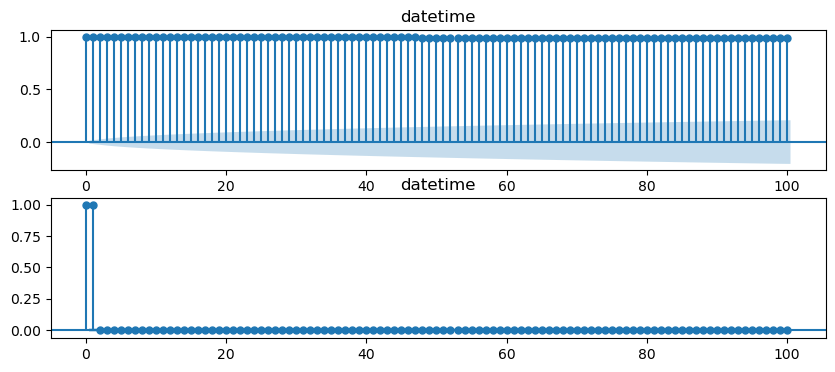

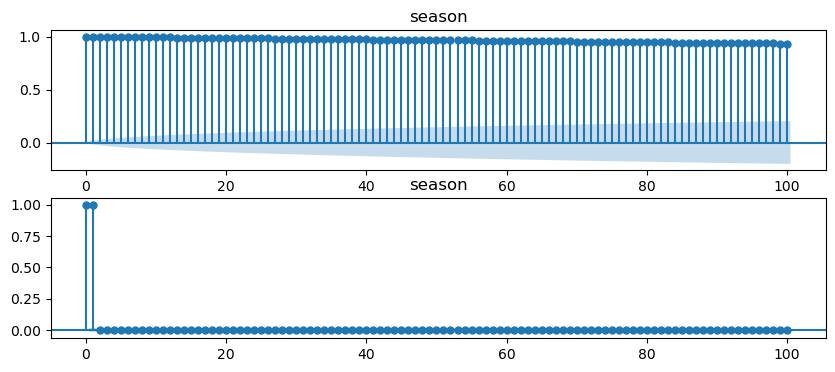

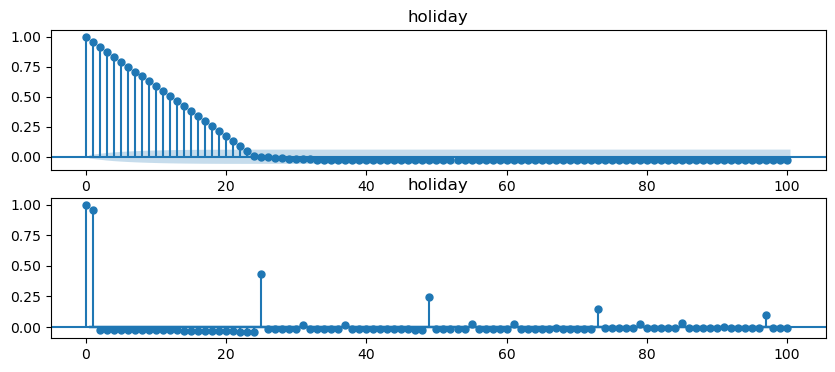

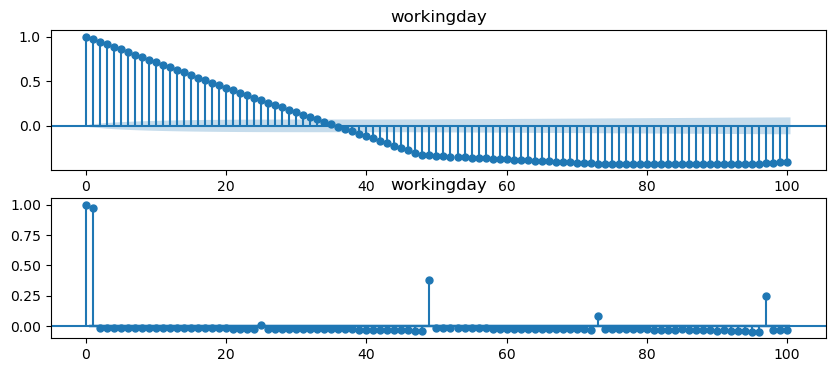

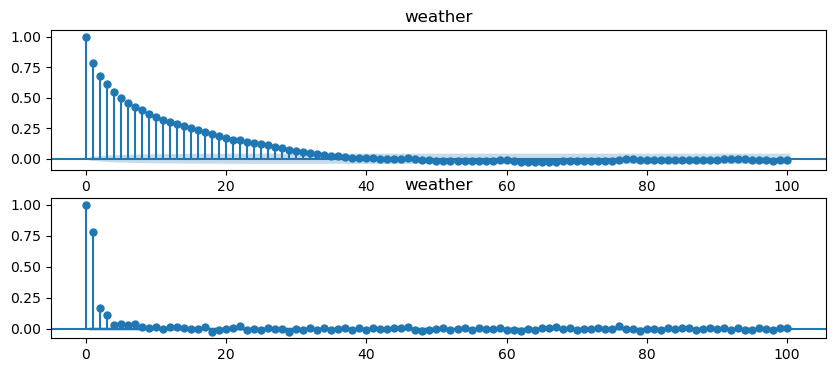

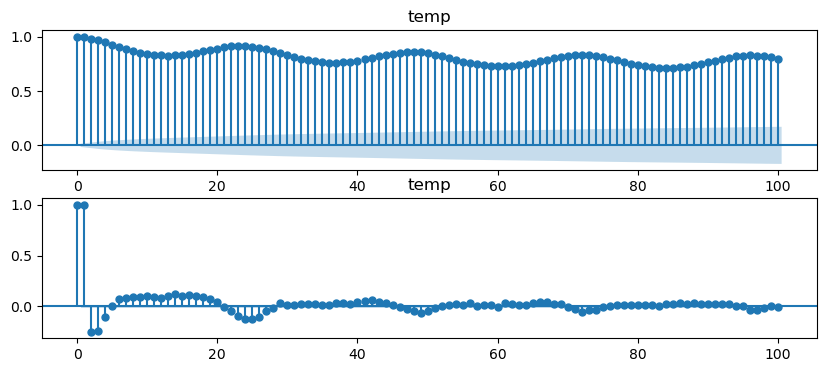

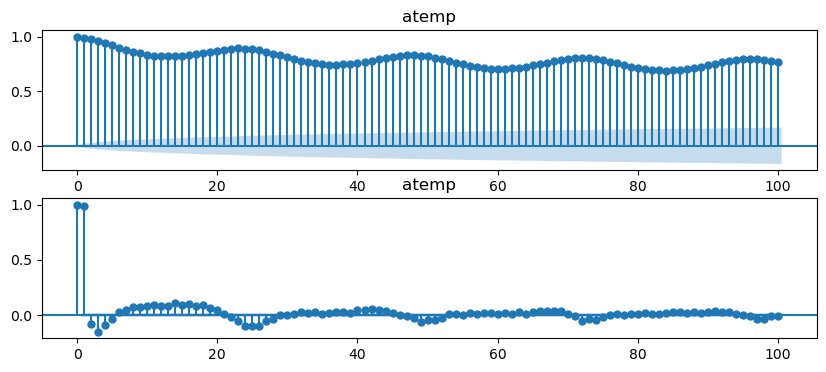

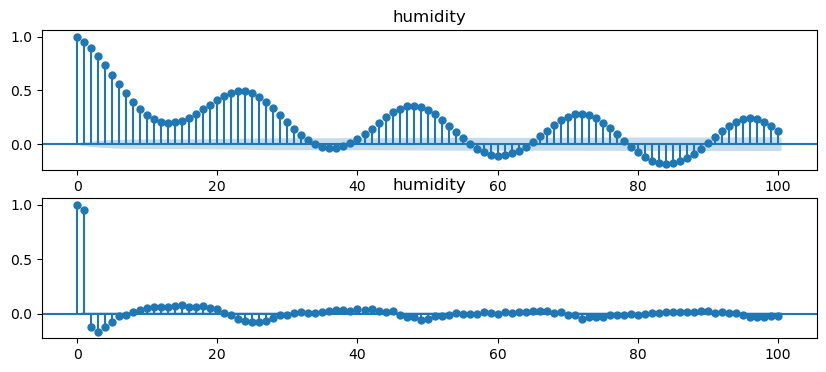

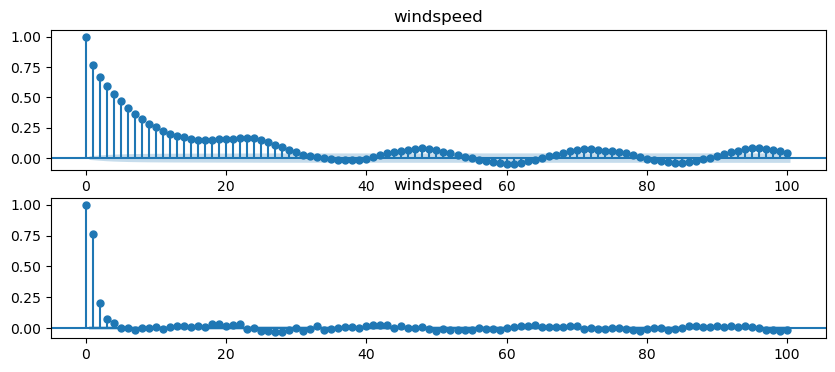

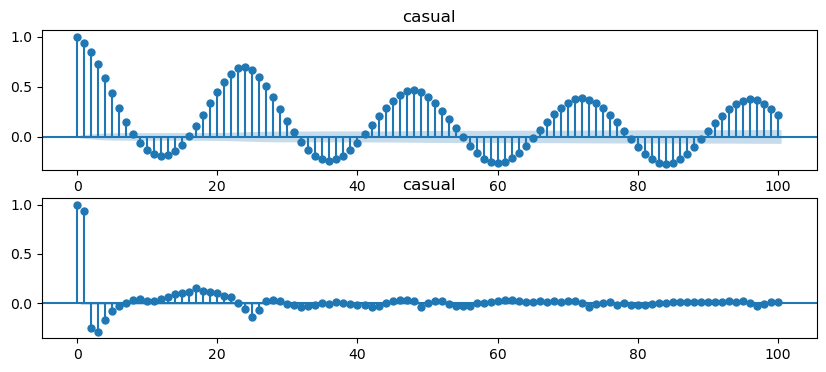

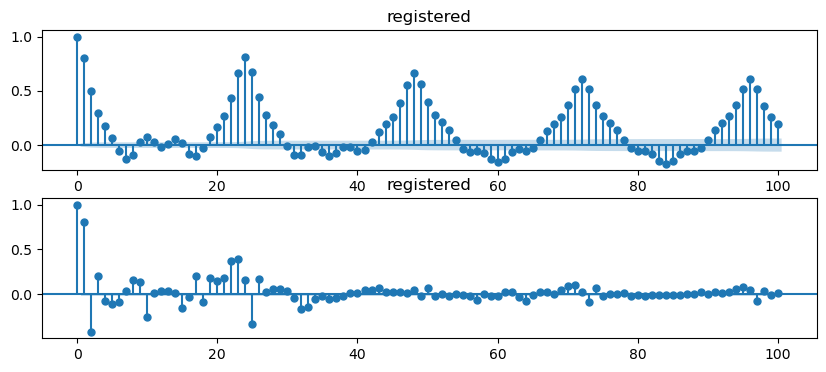

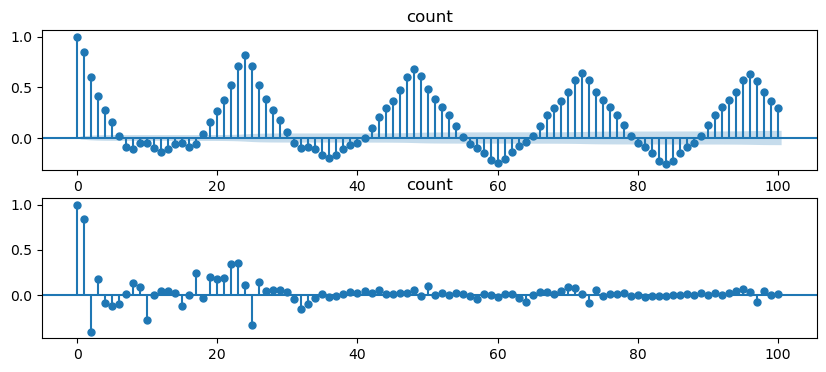

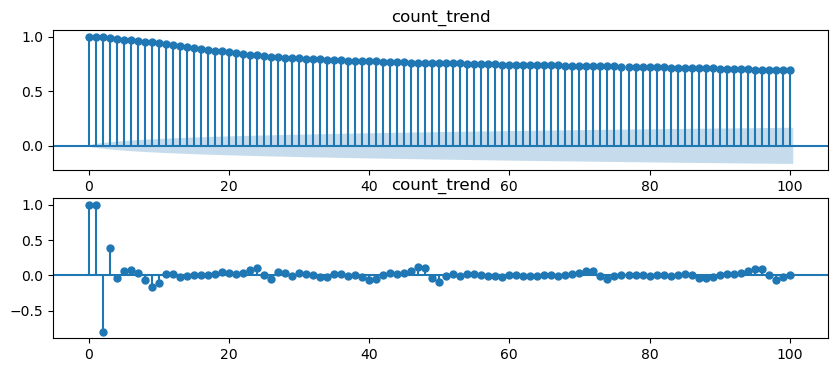

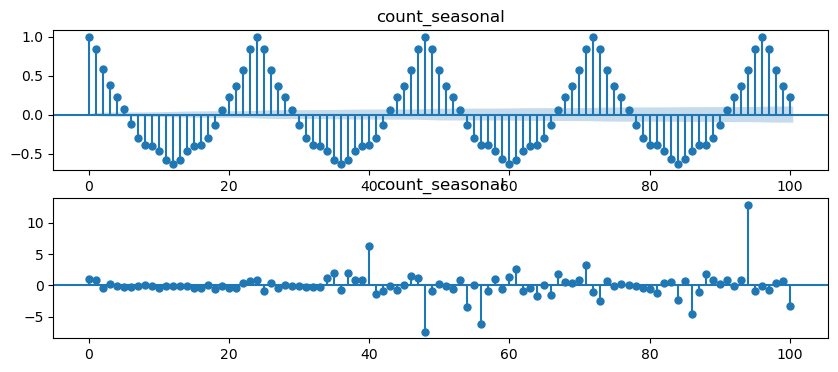

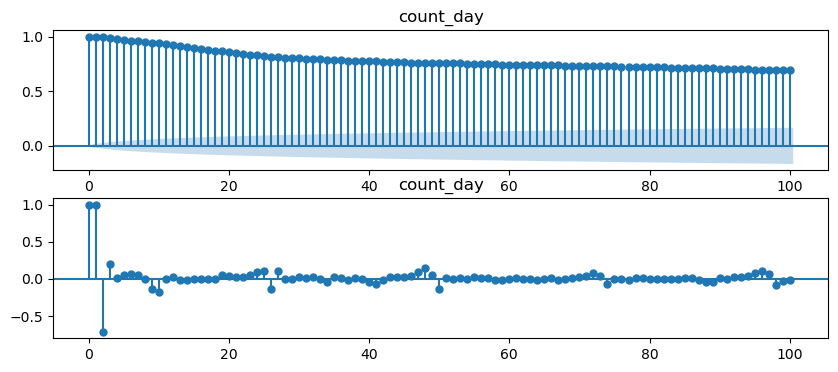

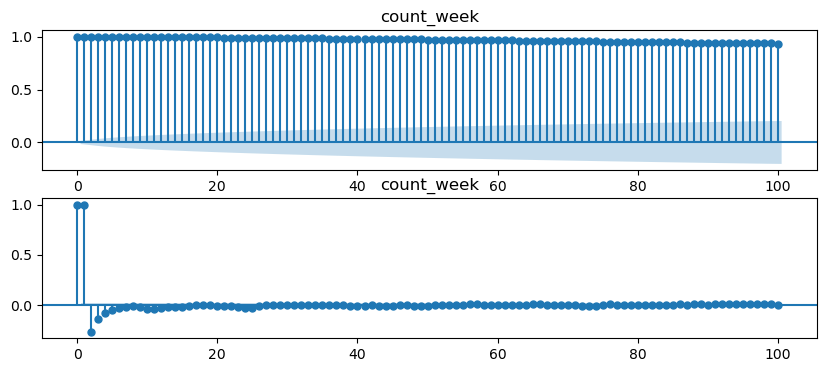

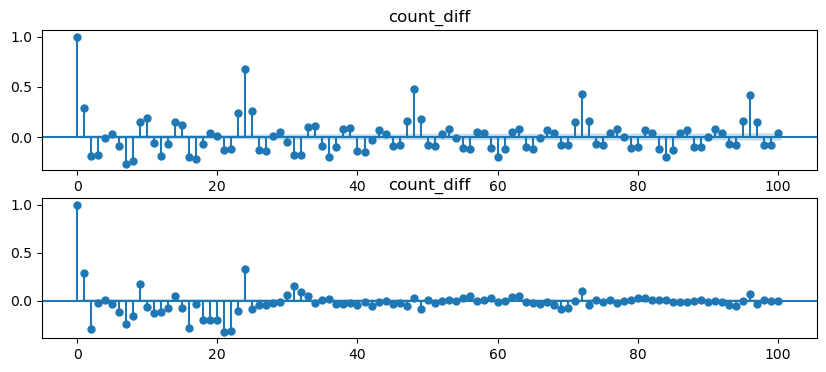

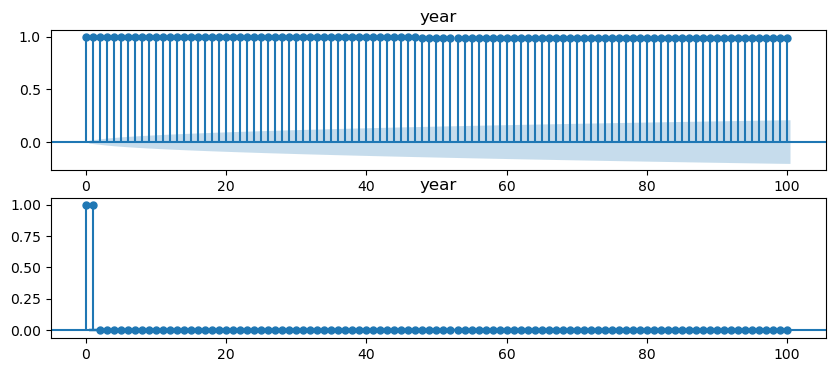

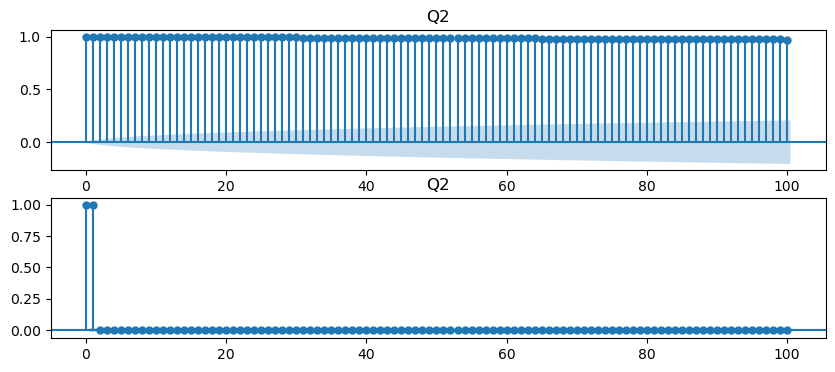

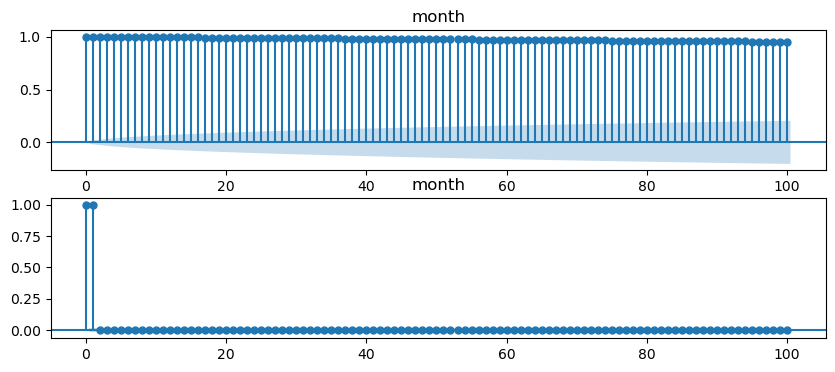

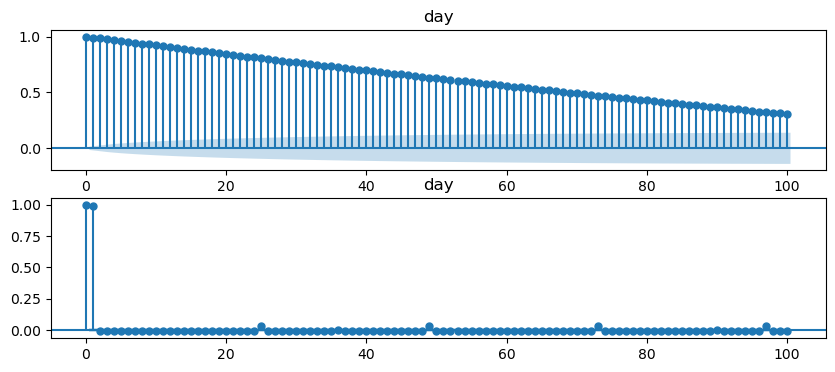

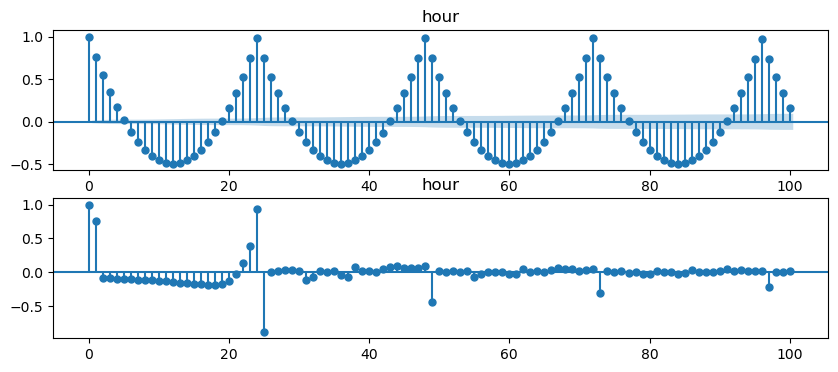

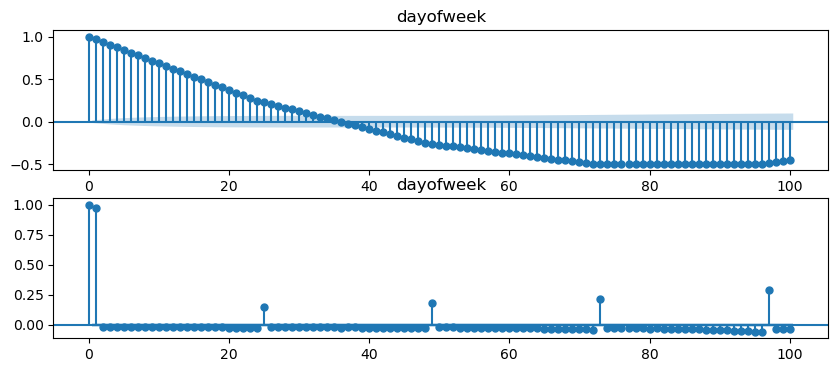

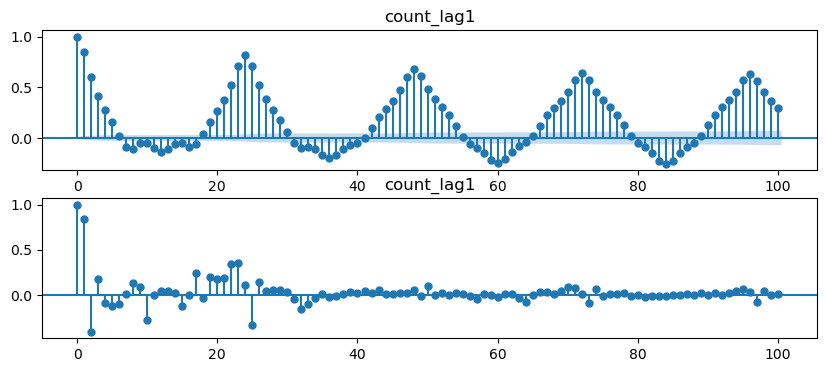

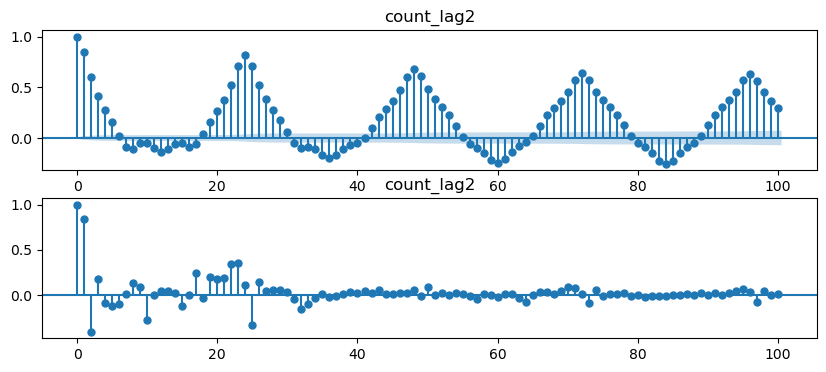

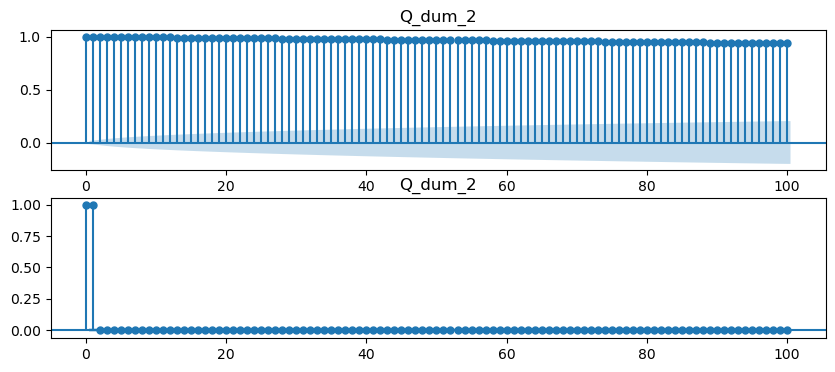

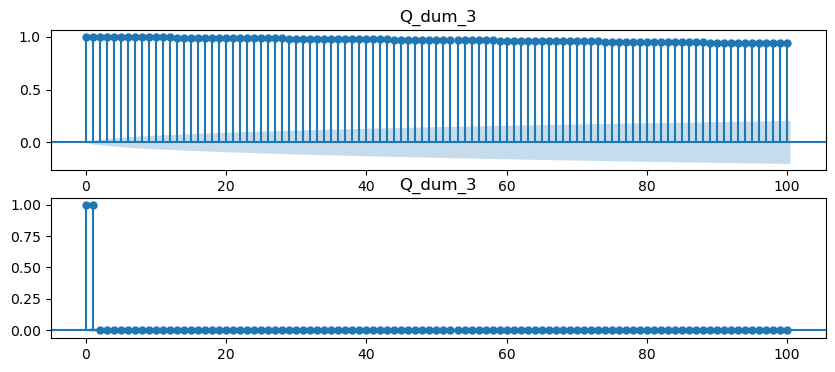

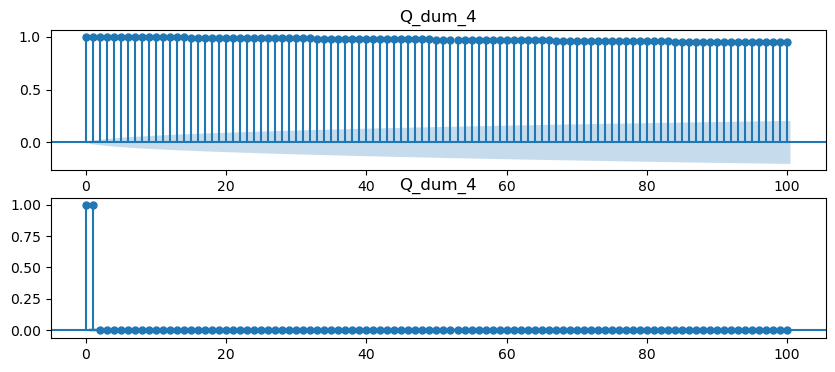

In [169]:
for col in data_fe.columns:
    target = data_fe[col]
    fig, axes = plt.subplots(2, 1, figsize=(10, 4))
    fig = sm.graphics.tsa.plot_acf(ax=axes[0], x=target, lags=100, use_vlines=True, title=col)
    fig = sm.graphics.tsa.plot_pacf(ax=axes[1], x=target, lags=100, use_vlines=True, title=col)

### VIF

In [226]:
def pickup_low_vif(x_tr, n_vars):
    vif = pd.DataFrame()
    vif["feat"] = x_tr.columns
    vif["vif"] = [variance_inflation_factor(x_tr.values, i) for i in range(x_tr.shape[1])]
    return vif.sort_values(by="vif", ascending=True)["feat"][:n_vars].values

In [ ]:
raw_data = pd.read_csv("./Data/BikeSharingDemand/Bike_Sharing_Demand_Full.csv")

data_fe = feature_engineering(raw_data)

target = ["count_trend", "count_seasonal", "count_day", "count_week", "count_diff"]
data_fe = duplicate_values(data_fe, target)

y_cols = ["count"]
x_cols = [x for x in data_fe.columns if x not in ["datetime", "casual", "registered"] + y_cols]
x_tr, y_tr, x_te, y_te = data_split(data_fe, x_cols=x_cols, y_cols=y_cols, crit="2012-07-01")

x_te = modify_lag(x_te, y_te, lags=[1, 2])

x_tr, x_te = scale_features(Normalizer(), x_tr, x_te)

eval_tr = pd.DataFrame()
eval_te = pd.DataFrame()
for i in tqdm(range(1, len(x_tr.columns) + 1)):
    cols = pickup_low_vif(x_tr_feRS, i)
    x_tr_copy, x_te_copy = x_tr[cols].copy(), x_te[cols].copy()
    
    fit_reg1_feRSM = sm.OLS(Y_train_feR, x_tr_copy).fit()
    pred_tr_reg1_feRSM = fit_reg1_feRSM.predict(x_tr_copy).values
    pred_te_reg1_feRSM = fit_reg1_feRSM.predict(x_te_copy).values

    # Evaluation
    Score_reg1_feRSM, Resid_tr_reg1_feRSM, Resid_te_reg1_feRSM = evaluation_trte(Y_train_feR, pred_tr_reg1_feRSM, y_teR, pred_te_reg1_feRSM, graph_on=False)
    eval_tr = pd.concat([eval_tr, Score_reg1_feRSM.loc[["Train"]]], axis=0)
    eval_te = pd.concat([eval_te, Score_reg1_feRSM.loc[["Test"]]], axis=0)
eval_tr.index = range(1,len(x_tr_feRS.columns)+1)
eval_te.index = range(1,len(x_tr_feRS.columns)+1)

plt.figure(figsize=(12,5))
plt.plot(eval_tr.index, eval_tr/eval_tr.max())
plt.legend(eval_tr.columns)
plt.title("Evaluation of Train Set")
plt.show()

plt.figure(figsize=(12,5))
plt.plot(eval_te.index, eval_te/eval_te.max())
plt.legend(eval_te.columns)
plt.title("Evaluation of Test Set")
plt.show()

In [ ]:
# Data Loading
# location = "https://raw.githubusercontent.com/cheonbi/DataScience/master/Data/Bike_Sharing_Demand_Full.csv"
location = "./Data/BikeSharingDemand/Bike_Sharing_Demand_Full.csv"
raw_data = pd.read_csv(location)

# Feature Engineering
data_fe = feature_engineering(raw_data)
### Reality ###
target = ["count_trend", "count_seasonal", "count_day", "count_week", "count_diff"]
data_fe = duplicate_values(data_fe, target)
###############

# Data Split
# Confirm of input and output
Y_colname = ["count"]
X_remove = ["datetime", "DateTime", "temp_group", "casual", "registered"]
X_colname = [x for x in data_fe.columns if x not in Y_colname+X_remove]
x_tr_feR, x_teR, Y_train_feR, y_teR = datasplit_ts(data_fe, Y_colname, X_colname, "2012-07-01")
### Reality ###
target = ["count_lag1", "count_lag2"]
x_teR = modify_lag(y_teR, x_teR, target)
###############
### Scaling ###
x_tr_feRS, x_teRS = scale_features(Normalizer(), x_tr_feR, x_teR)
###############
### Multicollinearity ###
print("Number_of_Total_X: ", len(x_tr_feRS.columns))
X_colname_vif = pickup_low_vif(x_tr_feRS, 12)
print("Number_of_Selected_X: ", len(X_colname_vif))
x_tr_feRSM, x_teRSM = x_tr_feRS[X_colname_vif].copy(), x_teRS[X_colname_vif].copy()
#########################

# Applying Base Model
fit_reg1_feRSM = sm.OLS(Y_train_feR, x_tr_feRSM).fit()
display(fit_reg1_feRSM.summary())
pred_tr_reg1_feRSM = fit_reg1_feRSM.predict(x_tr_feRSM).values
pred_te_reg1_feRSM = fit_reg1_feRSM.predict(x_teRSM).values

# Evaluation
Score_reg1_feRSM, Resid_tr_reg1_feRSM, Resid_te_reg1_feRSM = evaluation_trte(Y_train_feR, pred_tr_reg1_feRSM,
                                                                   y_teR, pred_te_reg1_feRSM, graph_on=True)
display(Score_reg1_feRSM)

# Error Analysis
error_analysis(Resid_tr_reg1_feRSM, ["Error"], x_tr_feRSM, graph_on=True)

# Final Result Comparison: 전처리(Raw/Reality/Scaling/Multicollinearity) 별 결과비교

In [ ]:
# comparison of metrics
comparison_r2 = pd.DataFrame([fit_reg1_rd.rsquared_adj, fit_reg1_feR.rsquared_adj, 
                              fit_reg1_feRS.rsquared_adj, fit_reg1_feRSM.rsquared_adj], 
                             index=["rd", "feR", "feRS", "feRSM"], columns=["R^2_adj"]).T
comparison_fvalue = pd.DataFrame([fit_reg1_rd.fvalue, fit_reg1_feR.fvalue, 
                                  fit_reg1_feRS.fvalue, fit_reg1_feRSM.fvalue], 
                                 index=["rd", "feR", "feRS", "feRSM"], columns=["F-statistics"]).T
comparison_fpvalue = pd.DataFrame([fit_reg1_rd.f_pvalue, fit_reg1_feR.f_pvalue, 
                                   fit_reg1_feRS.f_pvalue, fit_reg1_feRSM.f_pvalue], 
                                  index=["rd", "feR", "feRS", "feRSM"], columns=["prob(F-stat.)"]).T
comparison_aic = pd.DataFrame([fit_reg1_rd.aic, fit_reg1_feR.aic, 
                              fit_reg1_feRS.aic, fit_reg1_feRSM.aic], 
                             index=["rd", "feR", "feRS", "feRSM"], columns=["aic"]).T
comparison_bic = pd.DataFrame([fit_reg1_rd.bic, fit_reg1_feR.bic, 
                               fit_reg1_feRS.bic, fit_reg1_feRSM.bic], 
                              index=["rd", "feR", "feRS", "feRSM"], columns=["bic"]).T
pd.concat([comparison_r2, comparison_fvalue, comparison_fpvalue, comparison_aic, comparison_bic], axis=0)

In [ ]:
# comparison of coefficients
comparison_fit_rd = pd.concat([pd.DataFrame(fit_reg1_rd.params, columns=["coef"]), 
                               pd.DataFrame(fit_reg1_rd.pvalues, columns=["prob(coef)"])], axis=1)
comparison_fit_feR = pd.concat([pd.DataFrame(fit_reg1_feR.params, columns=["coef"]), 
                               pd.DataFrame(fit_reg1_feR.pvalues, columns=["prob(coef)"])], axis=1)
comparison_fit_feRS = pd.concat([pd.DataFrame(fit_reg1_feRS.params, columns=["coef"]), 
                               pd.DataFrame(fit_reg1_feRS.pvalues, columns=["prob(coef)"])], axis=1)
comparison_fit_feRSM = pd.concat([pd.DataFrame(fit_reg1_feRSM.params, columns=["coef"]), 
                               pd.DataFrame(fit_reg1_feRSM.pvalues, columns=["prob(coef)"])], axis=1)
pd.concat([comparison_fit_rd, comparison_fit_feR, comparison_fit_feRS, comparison_fit_feRSM], axis=1)

In [ ]:
target = Y_train_feR.copy()
stationarity_adf_test(target, "count")

In [ ]:
stationarity_kpss_test(target, "count")